In [1]:
%pylab inline
import numpy as np
import pylab as plt
from matplotlib.ticker import MultipleLocator

Populating the interactive namespace from numpy and matplotlib


In [34]:
import re
import tempfile
import subprocess
mtbleu = '/Users/jiataogu/Dropbox/UniNMT/UniNMT/src/dl4mt-tutorial/data/multi-bleu.perl'
def bleu(t, r):
    tf = tempfile.NamedTemporaryFile()
    tf.write(t)
    tf.flush()
    rf = tempfile.NamedTemporaryFile()
    rf.write(r)
    rf.flush()
    
    with open(tf.name, "r") as read_pred:
        bleu_cmd = [mtbleu]
        bleu_cmd += [rf.name]
        bleu_out = subprocess.check_output(
                    bleu_cmd, stdin=read_pred, stderr=subprocess.STDOUT)
        # print(bleu_out)
        # import sys; sys.exit(123)
        bleu_out = bleu_out.decode("utf-8")
        bleu_score = re.search(r"BLEU = (.+?),", bleu_out).group(1)
        bleu_score = float(bleu_score)
        return bleu_score

def bleu2(t, r):
    tf = tempfile.NamedTemporaryFile()
    tf.write('\n'.join(t))
    tf.write(b"\n")
    tf.flush()
    rf = tempfile.NamedTemporaryFile()
    rf.write('\n'.join(r))
    rf.write(b"\n")
    rf.flush()
    
    with open(tf.name, "r") as read_pred:
        bleu_cmd = [mtbleu]
        bleu_cmd += [rf.name]
        bleu_out = subprocess.check_output(
                    bleu_cmd, stdin=read_pred, stderr=subprocess.STDOUT)
        # print(bleu_out)
        # import sys; sys.exit(123)
        bleu_out = bleu_out.decode("utf-8")
        bleu_score = re.search(r"BLEU = (.+?),", bleu_out).group(1)
        bleu_score = float(bleu_score)
        return bleu_score

In [85]:
test_source = open('/Users/jiataogu/Work/K/MT-ComparEval/data/Ro.tst/source.txt').readlines()
train_source = open('/Users/jiataogu/Dropbox/UniNMT/UniNMT/data/src.ro.tok.6000').readlines()
test_reference = open('/Users/jiataogu/Work/K/MT-ComparEval/data/Ro.tst/reference.txt').readlines()
bas = open('/Users/jiataogu/Work/K/MT-ComparEval/data/Ro.tst/bas.romance.6k/translation.txt').readlines()
b60 = open('/Users/jiataogu/Work/K/MT-ComparEval/data/Ro.tst/bas.romance.60k/translation.txt').readlines()
lex = open('/Users/jiataogu/Work/K/MT-ComparEval/data/Ro.tst/lex.romance.6k/translation.txt').readlines()
let = open('/Users/jiataogu/Work/K/MT-ComparEval/data/Ro.tst/lex-ro-6k-bt/translation.txt').readlines()


In [71]:
train_voc = {}
for l in train_source:
    ws = l.strip().split()
    for w in ws:
        if w not in train_voc:
            train_voc[w] = 1
        else:
            train_voc[w] += 1
print(len(train_voc))




16369


55
0


55
0


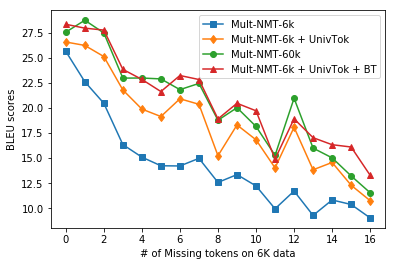

In [99]:
L = 3
p = 1 # 0.05
ms, bs, lx = [], [], []
for id in range(len(test_source)):
    # ms += [np.mean([train_voc.get(w, 0) < L for w in test_source[id].strip().split()])]
    ms += [np.sum([train_voc.get(w, 0) < L for w in test_source[id].strip().split()])]
ms = np.array(ms)

print(ms.max())
print(ms.min())
bass = [[] for _ in range(17)]
b60s = [[] for _ in range(17)]
lexs = [[] for _ in range(17)]
lets = [[] for _ in range(17)]
refs = [[] for _ in range(17)]
x = np.arange(17)
for i in range(ms.shape[0]):
    bi = int(np.floor(ms[i] / p))
    if bi >= len(bass):
        bi = len(bass)-1
    bass[bi].append(bas[i])
    b60s[bi].append(b60[i])
    lexs[bi].append(lex[i])
    lets[bi].append(let[i])
    refs[bi].append(test_reference[i])

A, B, C, D = [], [], [], []
for b, b2, l, l2, r in zip(bass, b60s, lexs, lets, refs):
    if len(b) > 0:
        A.append(bleu2(b, r))
        B.append(bleu2(l, r))
        C.append(bleu2(b2, r))
        D.append(bleu2(l2, r))
A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)
plt.plot(x, A, 's-')
plt.plot(x, B, 'd-')
plt.plot(x, C, 'o-')
plt.plot(x, D, '^-')
plt.legend(['Mult-NMT-6k', 'Mult-NMT-6k + UnivTok', 'Mult-NMT-60k',
           'Mult-NMT-6k + UnivTok + BT'])
plt.xlabel('# of Missing tokens')
plt.ylabel('BLEU scores')
plt.savefig('missing.pdf')

In [9]:
test_sent = [train_voc.get(w, 0) for w in test_source[10].strip().split()]
print(test_sent)

[138, 15, 7089, 26, 4665, 1705, 33, 0, 9, 2684, 67, 1, 994, 0, 0, 1744, 2, 0, 8602, 1172, 4193, 0, 508, 83, 489, 5685]


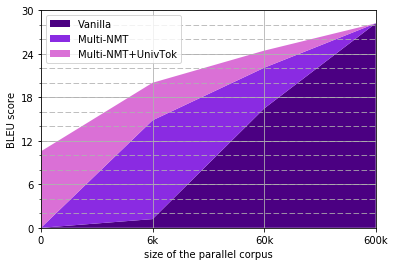

In [48]:
vanilla = np.array([0, 1.2, 16.46, 28.21])
multi   = np.array([0, 14.83, 22.08, 28.21])
univtok = np.array([10.55, 20.01, 24.44, 28.21])

y = np.row_stack((vanilla, multi-vanilla, univtok-multi))
x = np.arange(4)

majorLocator = MultipleLocator(6)
minorLocator = MultipleLocator(2)

fig, ax = plt.subplots()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_minor_locator(minorLocator)

ax.stackplot(x, y, colors=['indigo', 'blueviolet', 'orchid'])
plt.xticks( arange(4), ('0', '6k', '60k', '600k'))
plt.xlim([0, 3])
plt.ylim([0, 30])
ax.grid(which='major')
ax.grid(which='minor', linestyle='--', axis='y')
plt.xlabel('size of the parallel corpus')
plt.ylabel('BLEU score')
plt.legend(["Vanilla", "Multi-NMT", "Multi-NMT+UnivTok"], loc="upper left")
plt.savefig("size.pdf")
plt.show()

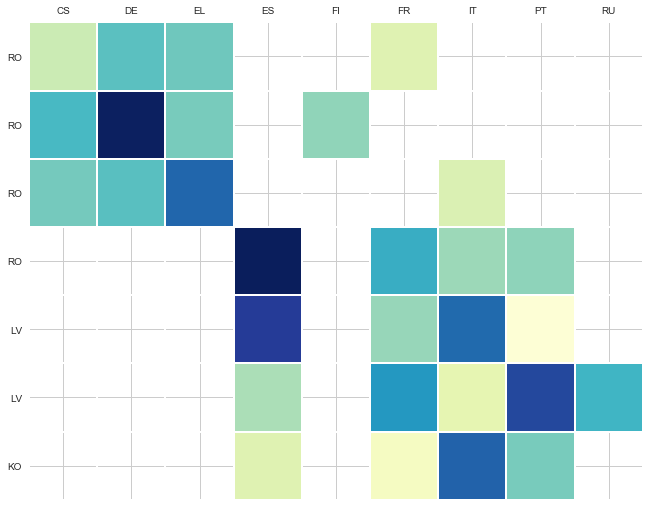

In [86]:
from string import ascii_letters
import pandas as pd
import seaborn as sns

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
data = rs.uniform(size=(7, 9))
d = pd.DataFrame(data=data,
                 columns=list(['CS', 'DE', 'EL', 'ES', 'FI', 'FR', 'IT', 'PT', 'RU']),
                 index=list(['RO', 'RO', 'RO', 'RO', 'LV', 'LV', 'KO']))

# Generate a mask for the upper triangle
mask = np.zeros_like(d, dtype=np.bool)

for k in [3, 4, 6, 7, 8]:
    mask[0,k] = True
for k in [3, 5, 6, 7, 8]:
    mask[1,k] = True
for k in [3, 4, 5, 7, 8]:
    mask[2,k] = True
for k in [0, 1, 2, 4, 8]:
    mask[3,k] = True
for k in [0, 1, 2, 4, 8]:
    mask[4,k] = True    
for k in [0, 1, 2, 4]:
    mask[5,k] = True  
for k in [0, 1, 2, 4, 8]:
    mask[6,k] = True
    
    
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
axx = sns.heatmap(d, mask=mask, cmap="YlGnBu", square=True, vmax=.2, center=0.5,
            linewidths=1, cbar=None)
for tick in axx.get_yticklabels():
    tick.set_rotation(0)
axx.xaxis.tick_top()
axx.grid(True)
plt.savefig("multi.pdf")